<a href="https://colab.research.google.com/github/Thanveerahmd/Fyp_Violence_transformer/blob/main/RLVS_video_transformer_50_diff_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration

/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration


In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

# Hyperparameters

In [5]:
MAX_SEQ_LENGTH = 50
NUM_FEATURES = 512
IMG_SIZE = 176

EPOCHS = 50

# Data preparation

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 1600
Total videos for testing: 400


In [7]:
# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


['NonViolence', 'Violence']


In [8]:
!ls

checkpoint		       saved_weight
rlvs_test_data_diff_50.npy     saved_weight.data-00000-of-00001
rlvs_test_labels_diff_50.npy   saved_weight.index
rlvs_train_data_diff_50.npy    test.csv
rlvs_train_labels_diff_50.npy  train.csv
saved_model


In [9]:
train_data, train_labels = np.load("rlvs_train_data_diff_50.npy"), np.load("rlvs_train_labels_diff_50.npy")
test_data, test_labels = np.load("rlvs_test_data_diff_50.npy"), np.load("rlvs_test_labels_diff_50.npy")

In [10]:
print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in train label set: {train_labels.shape}")
print(f"Frame features in test set: {test_data.shape}")
print(f"Frame features in test label set: {test_labels.shape}")

Frame features in train set: (1600, 50, 512)
Frame features in train label set: (1600, 1)
Frame features in test set: (400, 50, 512)
Frame features in test label set: (400, 1)


# Building the Transformer-based model

In [11]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [13]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 64
    num_heads = 8
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(embed_dim,return_sequences=True))(x)
    x = TransformerEncoder(2*embed_dim, dense_dim, num_heads, name="transformer_layer_1")(x)
    #x = TransformerEncoder(2*embed_dim, dense_dim, num_heads, name="transformer_layer_2")(x)
    #x = layers.Bidirectional(layers.LSTM(1024,return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(16)(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [14]:
model = get_compiled_model()

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 512)        25600     
 ositionalEmbedding)                                             
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       4198400   
 l)                                                              
                                                                 
 transformer_layer_1 (Transf  (None, None, 1024)       33716288  
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                              

# Model training and inference

In [16]:
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.21,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    # model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model,history

In [17]:
trained_model,history = run_experiment()

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 4.0389 - accuracy: 0.6195
Epoch 00001: val_loss improved from inf to 0.02431, saving model to /tmp/video_classifier
40/40 [==============================] - 57s 707ms/step - loss: 4.0389 - accuracy: 0.6195 - val_loss: 0.0243 - val_accuracy: 0.9970
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 1.6448 - accuracy: 0.7247
Epoch 00002: val_loss did not improve from 0.02431
40/40 [==============================] - 16s 403ms/step - loss: 1.6448 - accuracy: 0.7247 - val_loss: 1.3932 - val_accuracy: 0.4315
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 1.1868 - accuracy: 0.7785
Epoch 00003: val_loss did not improve from 0.02431
40/40 [==============================] - 18s 467ms/step - loss: 1.1868 - accuracy: 0.7785 - val_loss: 0.7898 - val_accuracy: 0.6964
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.8180
Epoch 00004: val_loss did not improv

# Learning Curves ( Evaluvation )

In [19]:
from matplotlib import pyplot

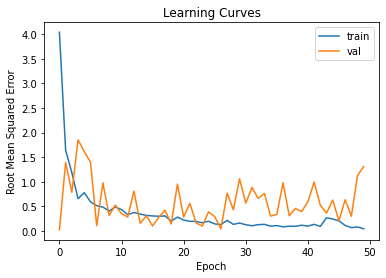

In [20]:
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Root Mean Squared Error')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()

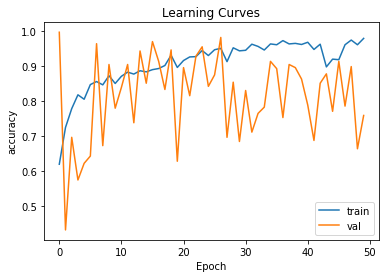

In [21]:
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='val')
    pyplot.legend()
    pyplot.show()

# Saving the model and model weights

In [22]:
# save model
!mkdir saved_model

# save model weights
!mkdir saved_weight

!ls

mkdir: cannot create directory ‘saved_model’: File exists
mkdir: cannot create directory ‘saved_weight’: File exists
checkpoint		       saved_weight
rlvs_test_data_diff_50.npy     saved_weight.data-00000-of-00001
rlvs_test_labels_diff_50.npy   saved_weight.index
rlvs_train_data_diff_50.npy    test.csv
rlvs_train_labels_diff_50.npy  train.csv
saved_model


In [23]:
model.save('/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration/saved_model')
model.save_weights('/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration/saved_weight')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration/saved_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration/saved_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Loading Pretrained model

In [24]:
model_arch = get_compiled_model()

In [25]:
model_arch.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 512)        25600     
 ositionalEmbedding)                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1024)       4198400   
 nal)                                                            
                                                                 
 transformer_layer_1 (Transf  (None, None, 1024)       33716288  
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 1024)             0         
 balMaxPooling1D)                                          

In [27]:
model_arch.load_weights("/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/acceleration/saved_weight")

In [28]:
_,accuracy = model_arch.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 10s 115ms/step - loss: 0.5599 - accuracy: 0.8975
Test accuracy: 89.75%
